In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy import stats

plt.rcParams['figure.figsize'] = (12, 6)


pd.set_option('display.float_format', lambda x: f'{x:.4f}')


### Fetch Historical Financial Data from YFinance for TSLA, BND, and SPY.

In [33]:
import os
import yfinance as yf
import pandas as pd

# -----------------------------
# 1️⃣ Set the raw data folder
# -----------------------------
raw_path = r"C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\raw"
os.makedirs(raw_path, exist_ok=True)

# -----------------------------
# 2️⃣ Define tickers and date range
# -----------------------------
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2026-01-15'

# Dictionary to hold each asset DataFrame
data_dict = {}

# -----------------------------
# 3️⃣ Fetch data and save individual CSVs
# -----------------------------
for ticker in tickers:
    print(f"Fetching {ticker}...")
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    if df.empty:
        print(f"⚠ Warning: {ticker} returned 0 rows. Skipping save.")
        continue
    
    # Reset index to make Date a column
    df.reset_index(inplace=True)
    
    # Prefix all columns except Date
    df = df.rename(columns={col: f"{ticker}_{col}" for col in df.columns if col != "Date"})
    
    # Save individual CSV
    file_path = os.path.join(raw_path, f"{ticker}_historical.csv")
    df.to_csv(file_path, index=False)
    print(f"{ticker} saved: {df.shape[0]} rows, {df.shape[1]} columns → {file_path}")
    
    data_dict[ticker] = df

# -----------------------------
# 4️⃣ Combine all DataFrames horizontally on Date
# -----------------------------
if data_dict:
    # Start with TSLA as base
    combined_df = data_dict[tickers[0]]
    
    for ticker in tickers[1:]:
        combined_df = combined_df.merge(data_dict[ticker], on="Date", how="outer")
    
    # Save combined CSV
    combined_file_path = os.path.join(raw_path, "all_assets_historical.csv")
    combined_df.to_csv(combined_file_path, index=False)
    print(f"Combined file saved: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns → {combined_file_path}")

# -----------------------------
# 5️⃣ Preview combined data
# -----------------------------
if 'combined_df' in locals():
    display(combined_df.head())


Fetching TSLA...
TSLA saved: 2775 rows, 6 columns → C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\raw\TSLA_historical.csv
Fetching BND...
BND saved: 2775 rows, 6 columns → C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\raw\BND_historical.csv
Fetching SPY...
SPY saved: 2775 rows, 6 columns → C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\raw\SPY_historical.csv
Combined file saved: 2775 rows, 16 columns → C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\raw\all_assets_historical.csv


C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_10460\696680998.py:53: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  combined_df = combined_df.merge(data_dict[ticker], on="Date", how="outer")


Price,Date,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
Ticker,,TSLA,TSLA,TSLA,TSLA,TSLA,BND,BND,BND,BND,BND,SPY,SPY,SPY,SPY,SPY
0,2015-01-02,14.6207,14.8833,14.2173,14.8580,71466000,60.3860,60.4152,60.2179,60.2253,2218800,170.5896,171.7937,169.5516,171.3785,121465900
1,2015-01-05,14.0060,14.4333,13.8107,14.3033,80527500,60.5613,60.5832,60.4225,60.4517,5820100,167.5088,169.7093,167.2015,169.5432,169632600
2,2015-01-06,14.0853,14.2800,13.6140,14.0040,93928500,60.7366,60.9193,60.6636,60.6636,3887600,165.9311,168.3392,165.1339,167.8161,209151400
3,2015-01-07,14.0633,14.3187,13.9853,14.2233,44526000,60.7732,60.8463,60.6782,60.7440,2433400,167.9988,168.3392,166.8113,167.2597,125346700
4,2015-01-08,14.0413,14.2533,14.0007,14.1873,51637500,60.6782,60.7221,60.6198,60.7221,1873400,170.9799,171.1958,169.3939,169.4105,147217800


### EDA, Trend Analysis & Risk Metrics

In [34]:


# Load the combined file
raw_file = r"C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\raw\all_assets_historical.csv"
df = pd.read_csv(raw_file, parse_dates=['Date'])

# Preview
display(df.head())

# Check basic info and data types
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Fill missing values if any
df.ffill(inplace=True)  # forward fill
df.bfill(inplace=True)  # backward fill

# Verify missing values handled
print("\nAfter filling missing values:")
print(df.isna().sum())


,Date,Close,High,Low,Open,Volume,Close.1,High.1,Low.1,Open.1,Volume.1,Close.2,High.2,Low.2,Open.2,Volume.2
0,NaT,TSLA,TSLA,TSLA,TSLA,TSLA,BND,BND,BND,BND,BND,SPY,SPY,SPY,SPY,SPY
1,2015-01-02,14.620667457580566,14.883333206176758,14.21733283996582,14.857999801635742,71466000,60.38599395751953,60.41521954734089,60.217948209599584,60.22525600060775,2218800,170.58961486816406,171.7937088796066,169.55161152791302,171.3785075435062,121465900
2,2015-01-05,14.005999565124512,14.433333396911621,13.810667037963867,14.303333282470703,80527500,60.56131362915039,60.583231417724015,60.422493535905886,60.451719112073604,5820100,167.50875854492188,169.70931964479044,167.20151373839448,169.5432417134495,169632600
3,2015-01-06,14.085332870483398,14.279999732971191,13.61400032043457,14.003999710083008,93928500,60.73664474487305,60.91930036484053,60.66358361172748,60.66358361172748,3887600,165.93106079101562,168.3392233667999,165.13386868532214,167.81606565147172,209151400
4,2015-01-07,14.063332557678223,14.3186674118042,13.985333442687988,14.223333358764648,44526000,60.7732048034668,60.84626596871684,60.678225846062695,60.74397922252486,2433400,167.99876403808594,168.33923217765732,166.81129428862295,167.25970616027502,125346700


<class 'pandas.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2775 non-null   datetime64[us]
 1   Close     2776 non-null   str           
 2   High      2776 non-null   str           
 3   Low       2776 non-null   str           
 4   Open      2776 non-null   str           
 5   Volume    2776 non-null   str           
 6   Close.1   2776 non-null   str           
 7   High.1    2776 non-null   str           
 8   Low.1     2776 non-null   str           
 9   Open.1    2776 non-null   str           
 10  Volume.1  2776 non-null   str           
 11  Close.2   2776 non-null   str           
 12  High.2    2776 non-null   str           
 13  Low.2     2776 non-null   str           
 14  Open.2    2776 non-null   str           
 15  Volume.2  2776 non-null   str           
dtypes: datetime64[us](1), str(15)
memory usage: 347.1 KB
None

Missing valu

In [35]:
# Convert all relevant columns to numeric
price_cols = [col for col in df.columns if col != 'Date' and col != 'Ticker']
df[price_cols] = df[price_cols].apply(pd.to_numeric, errors='coerce')

# Check conversion
print(df.dtypes)


Date        datetime64[us]
Close              float64
High               float64
Low                float64
Open               float64
Volume             float64
Close.1            float64
High.1             float64
Low.1              float64
Open.1             float64
Volume.1           float64
Close.2            float64
High.2             float64
Low.2              float64
Open.2             float64
Volume.2           float64
dtype: object


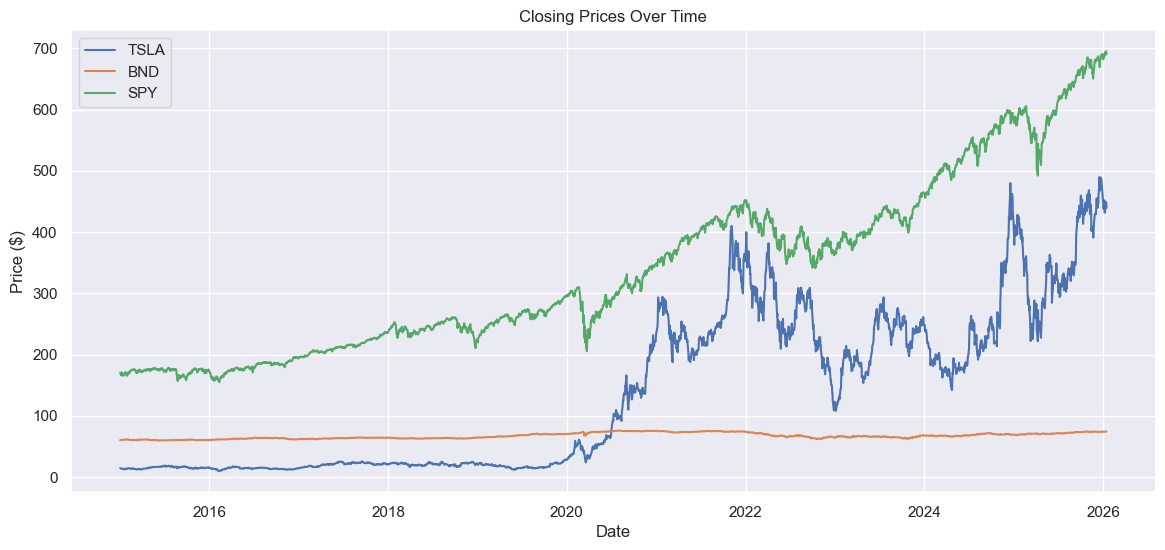

In [36]:


# Plot each asset's closing price over time
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='TSLA')
plt.plot(df['Date'], df['Close.1'], label='BND')
plt.plot(df['Date'], df['Close.2'], label='SPY')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


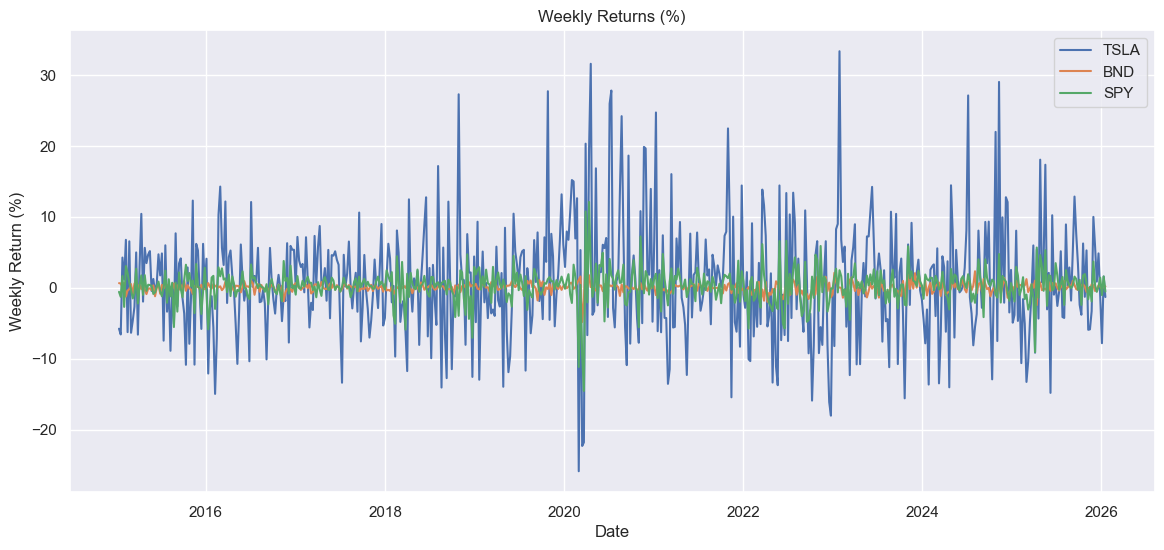

In [37]:
# Set Date as index for resampling
df.set_index('Date', inplace=True)

# Resample to weekly frequency and compute percentage change
weekly_returns = pd.DataFrame()
weekly_returns['TSLA'] = df['Close'].resample('W').last().pct_change() * 100
weekly_returns['BND'] = df['Close.1'].resample('W').last().pct_change() * 100
weekly_returns['SPY'] = df['Close.2'].resample('W').last().pct_change() * 100

# Reset index for plotting
weekly_returns.reset_index(inplace=True)

# Plot weekly returns
plt.figure(figsize=(14,6))
plt.plot(weekly_returns['Date'], weekly_returns['TSLA'], label='TSLA')
plt.plot(weekly_returns['Date'], weekly_returns['BND'], label='BND')
plt.plot(weekly_returns['Date'], weekly_returns['SPY'], label='SPY')
plt.title('Weekly Returns (%)')
plt.xlabel('Date')
plt.ylabel('Weekly Return (%)')
plt.legend()
plt.grid(True)
plt.show()


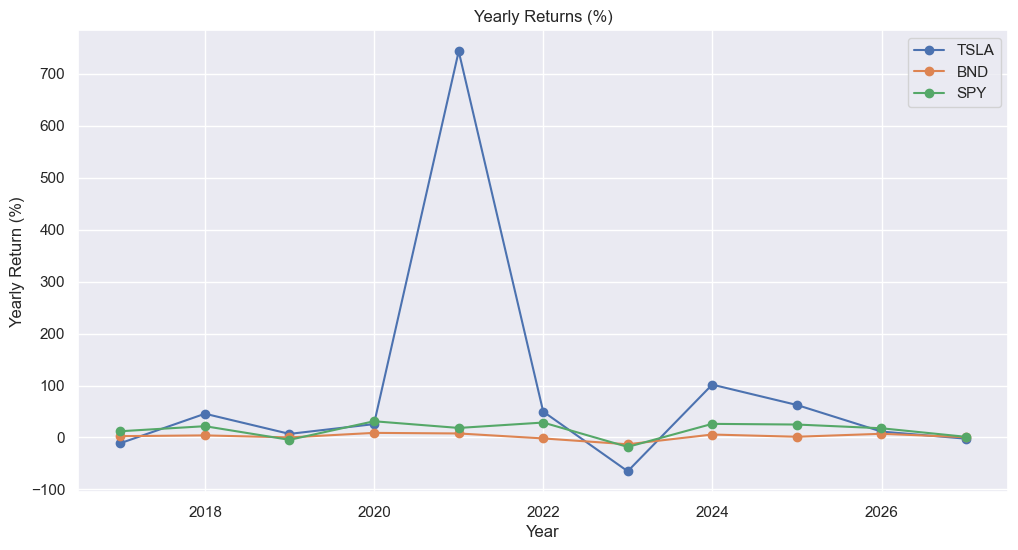

In [39]:
# Resample to yearly frequency and compute percentage change
yearly_returns = pd.DataFrame()
yearly_returns['TSLA'] = df['Close'].resample('YE').last().pct_change() * 100
yearly_returns['BND'] = df['Close.1'].resample('YE').last().pct_change() * 100
yearly_returns['SPY'] = df['Close.2'].resample('YE').last().pct_change() * 100

# Reset index for plotting
yearly_returns.reset_index(inplace=True)

# Plot yearly returns
plt.figure(figsize=(12,6))
plt.plot(yearly_returns['Date'], yearly_returns['TSLA'], marker='o', label='TSLA')
plt.plot(yearly_returns['Date'], yearly_returns['BND'], marker='o', label='BND')
plt.plot(yearly_returns['Date'], yearly_returns['SPY'], marker='o', label='SPY')
plt.title('Yearly Returns (%)')
plt.xlabel('Year')
plt.ylabel('Yearly Return (%)')
plt.legend()
plt.grid(True)
plt.show()


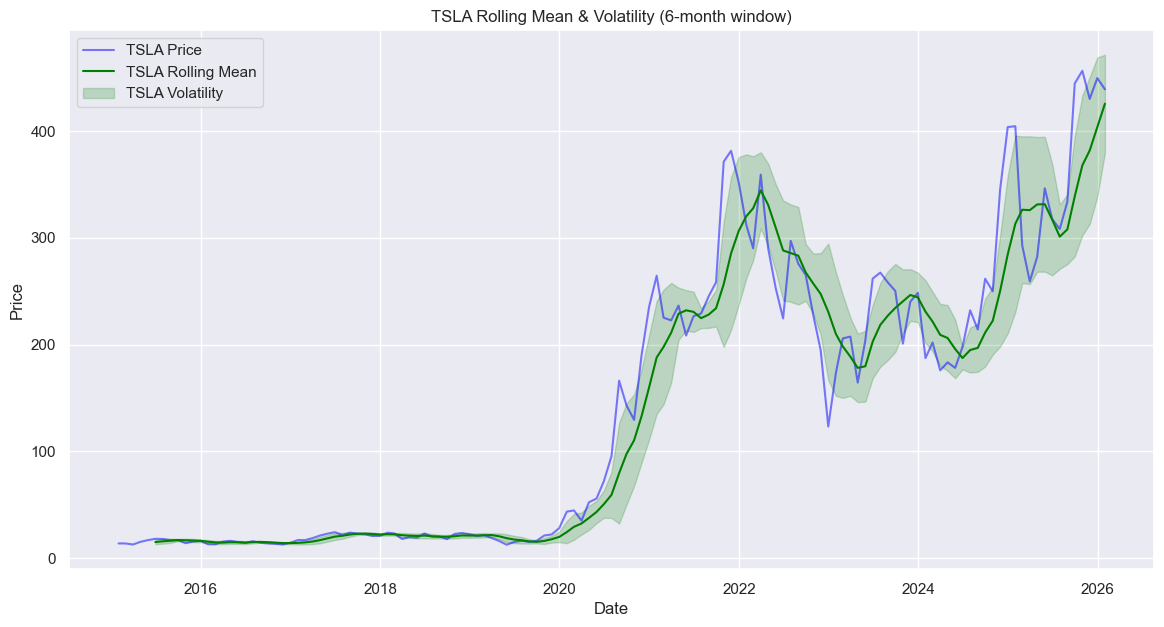

In [41]:
# Resample to monthly (month-end) for smoother rolling analysis
monthly_prices = pd.DataFrame()
monthly_prices['TSLA'] = df['Close'].resample('ME').last()
monthly_prices['BND'] = df['Close.1'].resample('ME').last()
monthly_prices['SPY'] = df['Close.2'].resample('ME').last()

# Calculate rolling mean (6 months) and rolling std (volatility)
rolling_window = 6
rolling_stats = pd.DataFrame()
for col in monthly_prices.columns:
    rolling_stats[f'{col}_mean'] = monthly_prices[col].rolling(rolling_window).mean()
    rolling_stats[f'{col}_std'] = monthly_prices[col].rolling(rolling_window).std()

# Plot TSLA rolling mean & volatility
plt.figure(figsize=(14,7))
plt.plot(monthly_prices.index, monthly_prices['TSLA'], label='TSLA Price', color='blue', alpha=0.5)
plt.plot(rolling_stats.index, rolling_stats['TSLA_mean'], label='TSLA Rolling Mean', color='green')
plt.fill_between(rolling_stats.index, 
                 rolling_stats['TSLA_mean'] - rolling_stats['TSLA_std'], 
                 rolling_stats['TSLA_mean'] + rolling_stats['TSLA_std'], 
                 color='green', alpha=0.2, label='TSLA Volatility')
plt.title('TSLA Rolling Mean & Volatility (6-month window)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


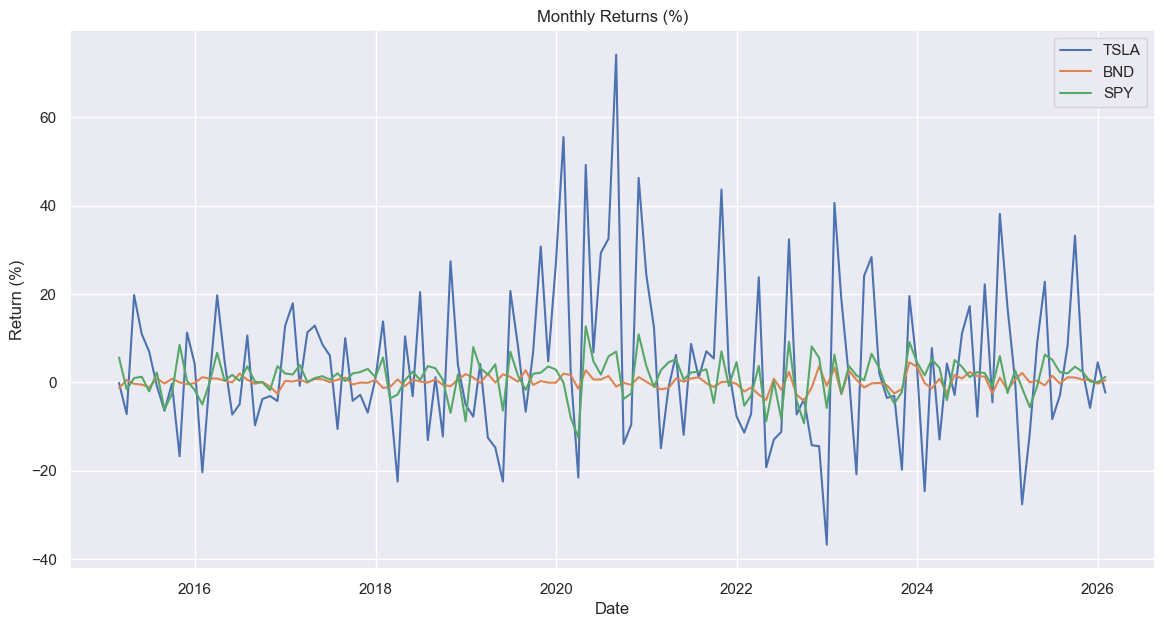

          TSLA      BND      SPY
count 132.0000 132.0000 132.0000
mean    4.0827   0.1533   1.1794
std    17.7412   1.4374   4.3022
min   -36.7334  -4.1830 -12.4872
25%    -7.2569  -0.5909  -1.0816
50%     1.1420   0.1511   1.7373
75%    11.6060   0.8796   3.6890
max    74.1452   4.5414  12.6983


In [42]:
# Calculate monthly returns (%) for all assets
monthly_returns = monthly_prices.pct_change() * 100

# Plot monthly returns to visualize volatility
plt.figure(figsize=(14,7))
for col in monthly_returns.columns:
    plt.plot(monthly_returns.index, monthly_returns[col], label=col)
plt.title('Monthly Returns (%)')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.show()

# Summary statistics for returns
returns_stats = monthly_returns.describe()
print(returns_stats)



Outlier months for TSLA:
Series([], Freq: ME, Name: TSLA, dtype: float64)

Outlier months for BND:
Series([], Freq: ME, Name: BND, dtype: float64)

Outlier months for SPY:
Series([], Freq: ME, Name: SPY, dtype: float64)


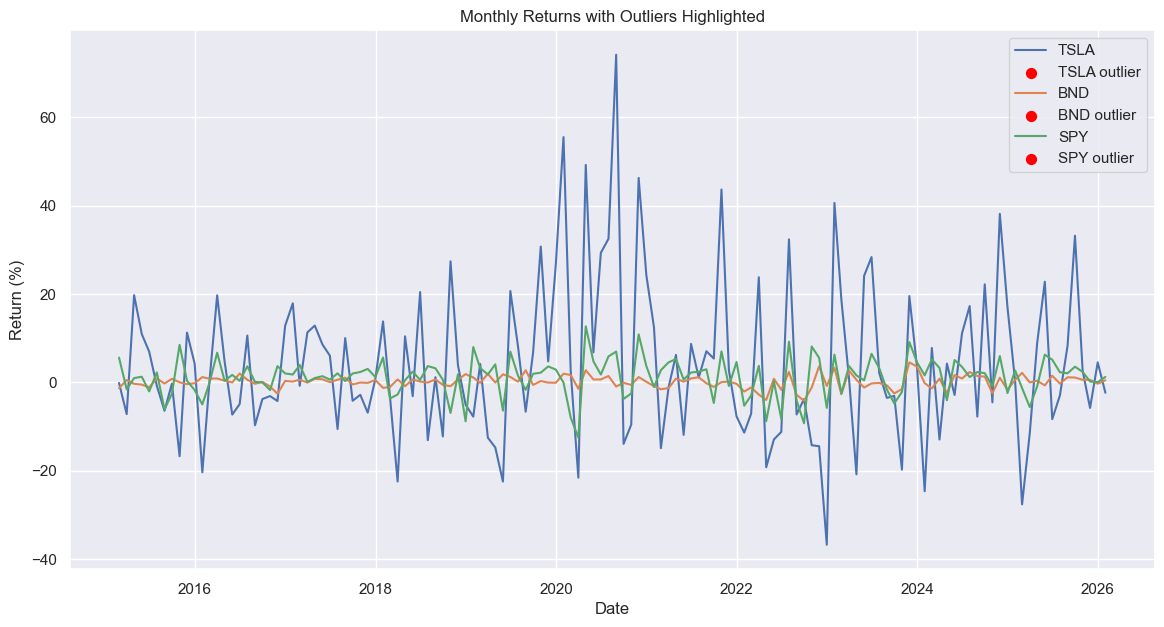

In [43]:
from scipy.stats import zscore

# Calculate z-scores for monthly returns
z_scores = monthly_returns.apply(zscore)

# Set a threshold for outliers (e.g., |z| > 3)
outliers = (z_scores.abs() > 3)

# Display outlier months
for col in monthly_returns.columns:
    print(f"\nOutlier months for {col}:")
    print(monthly_returns[col][outliers[col]])

# Optional: visualize outliers on a plot
plt.figure(figsize=(14,7))
for col in monthly_returns.columns:
    plt.plot(monthly_returns.index, monthly_returns[col], label=col)
    plt.scatter(monthly_returns.index[outliers[col]], 
                monthly_returns[col][outliers[col]], 
                color='red', s=50, label=f'{col} outlier')
plt.title('Monthly Returns with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"\nADF Test for {name}:")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print(f"  # Lags used    : {result[2]}")
    print(f"  # Observations : {result[3]}")
    if result[1] < 0.05:
        print(f"  → {name} is likely stationary (reject H0)")
    else:
        print(f"  → {name} is likely non-stationary (fail to reject H0)")

# Apply ADF test to each asset's monthly returns
for col in monthly_returns.columns:
    adf_test(monthly_returns[col], col)



ADF Test for TSLA:
  Test Statistic : -4.3027
  p-value        : 0.0004
  # Lags used    : 3
  # Observations : 128
  → TSLA is likely stationary (reject H0)

ADF Test for BND:
  Test Statistic : -11.1177
  p-value        : 0.0000
  # Lags used    : 0
  # Observations : 131
  → BND is likely stationary (reject H0)

ADF Test for SPY:
  Test Statistic : -9.9623
  p-value        : 0.0000
  # Lags used    : 1
  # Observations : 130
  → SPY is likely stationary (reject H0)


In [45]:


# Function to calculate risk metrics
def risk_metrics(returns, name):
    mean_ret = returns.mean()
    std_ret = returns.std()
    
    # Historical 5% Value at Risk (VaR)
    var_5 = np.percentile(returns.dropna(), 5)
    
    # Sharpe Ratio (assume risk-free rate = 0 for simplicity)
    sharpe = mean_ret / std_ret if std_ret != 0 else np.nan
    
    print(f"\n{name} Risk Metrics:")
    print(f"  Mean Return : {mean_ret:.2f}%")
    print(f"  Std Dev     : {std_ret:.2f}%")
    print(f"  5% VaR      : {var_5:.2f}%")
    print(f"  Sharpe Ratio: {sharpe:.2f}")

# Apply to each asset
for col in monthly_returns.columns:
    risk_metrics(monthly_returns[col], col)



TSLA Risk Metrics:
  Mean Return : 4.08%
  Std Dev     : 17.74%
  5% VaR      : -20.54%
  Sharpe Ratio: 0.23

BND Risk Metrics:
  Mean Return : 0.15%
  Std Dev     : 1.44%
  5% VaR      : -2.47%
  Sharpe Ratio: 0.11

SPY Risk Metrics:
  Mean Return : 1.18%
  Std Dev     : 4.30%
  5% VaR      : -6.62%
  Sharpe Ratio: 0.27


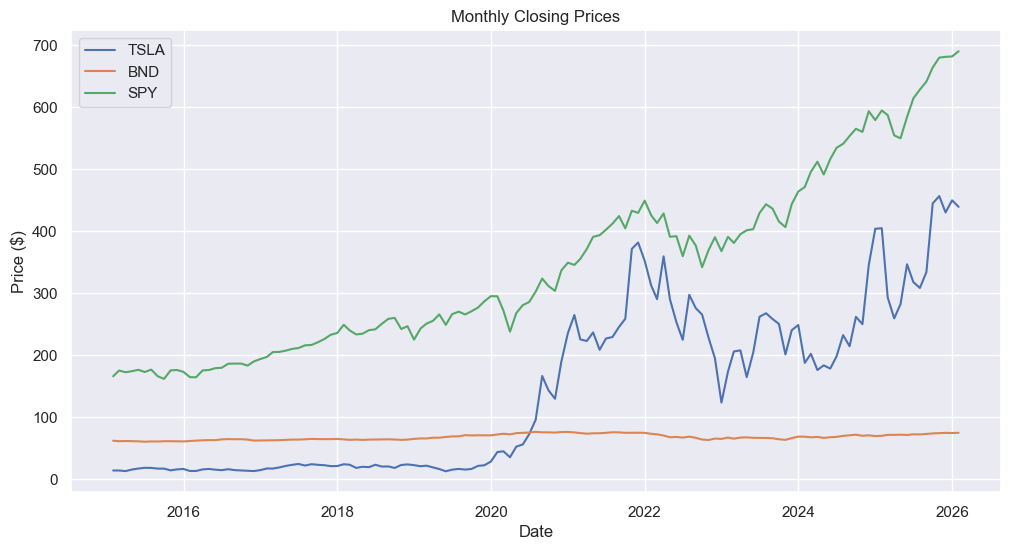

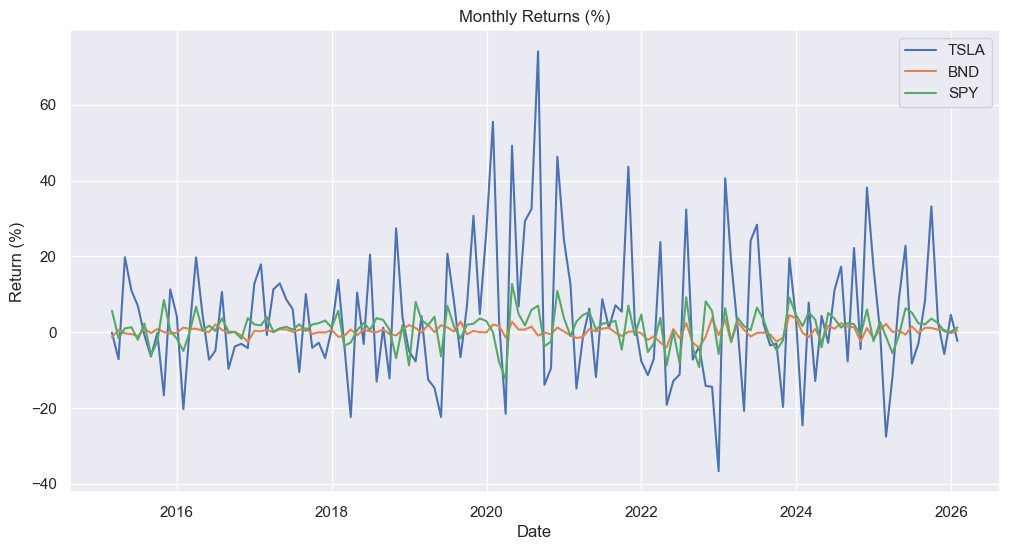

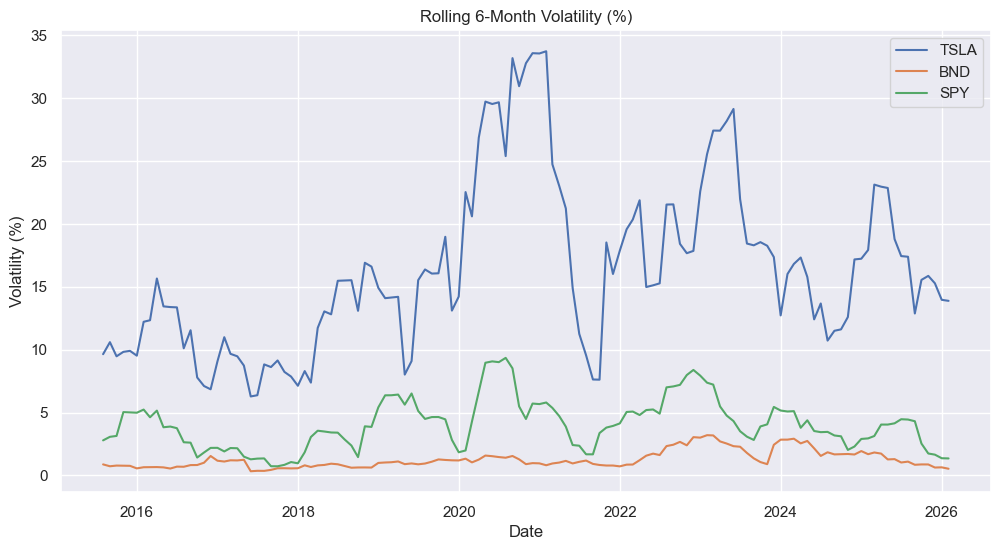

In [ ]:


# 1️⃣ Closing Prices Over Time
plt.figure(figsize=(12,6))
plt.plot(monthly_prices.index, monthly_prices['TSLA'], label='TSLA')
plt.plot(monthly_prices.index, monthly_prices['BND'], label='BND')
plt.plot(monthly_prices.index, monthly_prices['SPY'], label='SPY')
plt.title("Monthly Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# 2️⃣ Monthly Returns Over Time
plt.figure(figsize=(12,6))
plt.plot(monthly_returns.index, monthly_returns['TSLA'], label='TSLA')
plt.plot(monthly_returns.index, monthly_returns['BND'], label='BND')
plt.plot(monthly_returns.index, monthly_returns['SPY'], label='SPY')
plt.title("Monthly Returns (%)")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()
plt.show()

# 3️⃣ Rolling Volatility (6-month window)
rolling_window = 6
plt.figure(figsize=(12,6))
plt.plot(monthly_returns['TSLA'].rolling(rolling_window).std(), label='TSLA')
plt.plot(monthly_returns['BND'].rolling(rolling_window).std(), label='BND')
plt.plot(monthly_returns['SPY'].rolling(rolling_window).std(), label='SPY')
plt.title(f"Rolling {rolling_window}-Month Volatility (%)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.show()
